# El Perceptrón Multicapa - Clasificación

In [ ]:
''' NOMBRE: Sebastian Gonzales Tito
CARRERA: Ing. Sistemas


Modelo para prediccion de numeros con Redes Neuronales usando Modelos de Clasificacion Multicapa
Usando como activacion el algoritmo RELU y tambien crossentropy.

Cambiando valores de Capas Ocultas, Numero de iteraciones y calor de coeficiente 
'''

## El Perceptrón Multicapa

En el [post](https://sensioai.com/blog/023_mlp_backprop) anterior hemos introducido el modelo de `Perceptrón Multicapa`, o MLP, la arquitectura de red neuronal más básica basada en el [Perceptrón](https://sensioai.com/blog/012_perceptron1). Hemos visto cómo calcular la salida de un MLP de dos capas a partir de unas entradas y cómo encontrar los pesos óptimos para una tarea de regresión. En este post vamos a mejorar la implementación de nuestro MLP de dos capas para que sea capaz también de llevar a cabo tareas de clasificación.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

## Implementación

La mayoría del código que utilizaremos fue desarrollado para el `Perceptrón` y lo puedes encontrar en este [post](https://sensioai.com/blog/018_perceptron_final). Lo único que cambiaremos es la lógica del modelo, el resto de funcionalidad (funciones de pérdida, funciones de activación, etc, siguen siendo exactamente igual).

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [98]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida crossentropy, CE).

In [99]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Como acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [100]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [101]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [102]:
# clase base MLP 

class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    # función de pérdida y derivada
    self.loss = loss
    self.grad_loss = grad_loss
    # función de activación
    self.activation = activation

  def __call__(self, x):
    # salida de la capa 1
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    # salida del MLP
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.activation(y_hat)
    
  def fit(self, X, Y, epochs = 100, lr = 0.001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):     
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            # batch de datos
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size] 
            # salida del perceptrón
            y_pred = self(x) 
            # función de pérdida
            loss = self.loss(y, y_pred)
            _l.append(loss)        
            # Backprop 
            dldy = self.grad_loss(y, y_pred) 
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        # guardamos pesos intermedios para visualización
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [103]:
# MLP para regresión
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)

# MLP para clasificación binaria
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)

# MLP para clasificación multiclase
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, relu)

Vamos a probar ahora nuestra implementación para diferentes ejemplos.

## Clasificación Multiclase

Por último vamos a ver cómo aplicar nuestro modelo para clasificación en multiples clases.

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from matplotlib import pyplot

In [105]:
""" X = iris.data[:, (2, 3)]  # petal length, petal width
y = iris.target

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show() """
data = loadmat(os.path.join('ex3data1.mat'))
X, y = data['X'], data['y'].ravel()
print(y)
y[y == 10] = 0

[10 10 10 ...  9  9  9]


In [106]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

def correccionPredict(predic):
  L_mayor = []
  for value in predic:
    mayor = 0
    for index in range(len(value)):
      if(value[index] > value[mayor]):
        mayor = index
    L_mayor.append(mayor)

  return L_mayor

In [107]:
model = MLPClassification(D_in=400, H=250, D_out=10)
epochs, lr = 2000, 0.1
model.fit(X, y, epochs, lr, batch_size=4999, log_each=200)

Epoch: 200/2000, Loss: 0.72576
Epoch: 400/2000, Loss: 0.51941
Epoch: 600/2000, Loss: 0.43094
Epoch: 800/2000, Loss: 0.37793
Epoch: 1000/2000, Loss: 0.34091
Epoch: 1200/2000, Loss: 0.31268
Epoch: 1400/2000, Loss: 0.28996
Epoch: 1600/2000, Loss: 0.27103
Epoch: 1800/2000, Loss: 0.25484
Epoch: 2000/2000, Loss: 0.24074


In [108]:
X_prueba = X[1899:1999, :].copy()
prediccionModelo = model.predict([model.w1, model.b1, model.w2, model.b2], X_prueba)
print( 'El entrenamiento tiene una precision de {:.2f}%'.format(np.mean(correccionPredict(prediccionModelo) == y[1899:1999])* 100))

El entrenamiento tiene una precision de 95.00%


3
[[0.         2.62924024 0.76549085 9.3670391  0.         2.54646465
  0.         0.         5.1111372  0.        ]]


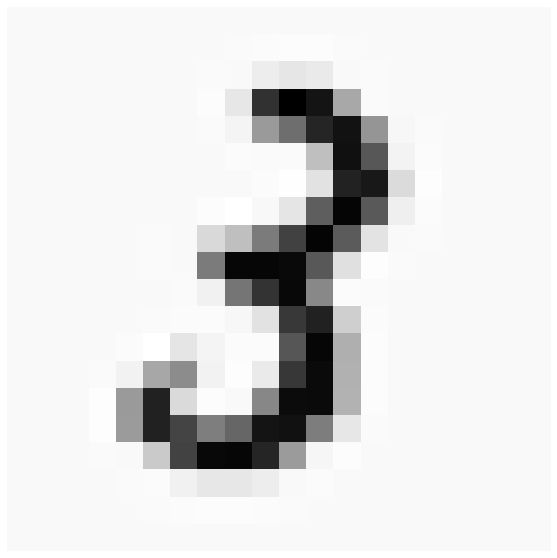

In [109]:
X_prueba = X[1899:1900, :].copy()
print(y[1900])
prediccionModelo = model.predict([model.w1, model.b1, model.w2, model.b2], X_prueba)
print(prediccionModelo)
displayData(X_prueba)

De nuevo, nuestro MLP es capaz de separar las tres clases en el dataset. En posts anteriores hemos trabajado también con el dataset MNIST para clasificación de imágenes en diez clases distintas. ¿Te ves capaz de utilizar nuestro MLP para resolver ese problema?

## Resumen

En este post hemos visto como implementar un `Perceptrón Multicapa` en `Python` para tareas de regresión y clasificación. Como ya hicimos anteriormente para el caso del `Perceptrón` hemos validado nuestra implementación con el dataset de clasificación de flores *Iris*, tanto para clasificación binaria como multiclase. Sin embargo, nuestra implementación está muy limitada. ¿Qué pasa si queremos usar un MLP de más de dos capas?, ¿y si queremos usar una función de activación diferente a la `relu` en la capa oculta?, ¿podríamos utilizar un algoritmo de optimizaciñon diferente al `descenso por gradiente`? Para poder hacer todo esto necesitamos un `framework` más flexible, similar a lo que nos ofrecen `Pytorch` y `Tensorflow`. En el siguiente post desarrollaremos nuestro propio framework de MLP para que sea más flexible y que también nos servirá para entender cómo funcionan el resto de frameworks de `redes neuronales` por dentro.